# CS675 Introduction to Data Science - Project #2

**Darpan Gorasiya**
The dataset consists of a CSV file that holds information regarding customer churn within the telecommunications sector. Analyzing churn is crucial for businesses because elevated churn rates suggest customer dissatisfaction, while lower rates indicate a content customer base, meaning they are less inclined to switch to competitors. Consequently, understanding churn rates, forecasting potential churn, and enhancing services to maintain low churn levels is vital for companies.

In our analysis, we will employ four models across three phases:

Standard prediction techniques
Implementing SMOTE techniques to tackle data imbalance in our predictions
Using standard methods enhanced by hyperparameter tuning for optimizing predictions (specifically with Random Forest and XGBoost)
As outlined in the brief, we will utilize the following four algorithms to make predictions about customer churn:

Naive Bayes
Logistic Regression
Random Forest
XGBoost
For each model and analysis phase, we will assess the following performance metrics:

Accuracy
Precision
Recall
F1 Score


In [ ]:
# importing packages for data cleaning, visualization, and EDA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly
import statsmodels
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from xgboost import XGBRegressor
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# reading the raw CSV data file
df = pd.read_csv("telco-customer-churn.csv")

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# getting unique values from each column, so we know which values to convert to numerical
for col in df.columns:
    print(col,df[col].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (a

In [ ]:
# Define a mapping dictionary for label encoding
encoding_map = {
    "Yes": 1,
    "No": 0,
    "Female": 0,
    "Male": 1,
    "No phone service": 2,
    "No internet service": 3,
    "DSL": 4,
    "Fiber optic": 5,
    "Month-to-month": 6,
    "One year": 7,
    "Two year": 8,
    "Electronic check": 9,
    "Mailed check": 10,
    "Bank transfer (automatic)": 11,
    "Credit card (automatic)": 12,
    " ": -1  # Handle missing values
}

# Performing label encoding using the mapping
for col in df.columns:
    df[col] = df[col].map(encoding_map).fillna(-1).astype(int)


In [ ]:
# obtaining list of all columns which we need to convert
cols_to_convert_to_int = df.columns[np.where(df.dtypes=="object")]
cols_to_convert_to_int = cols_to_convert_to_int[1:] # we are excluding the customerID column

In [ ]:
# converting each of the targeted columns to integer type
for col in cols_to_convert_to_int:
    df[col] = pd.to_numeric(df[col])

In [ ]:
# checking the data types
df.dtypes

,0
customerID,object
gender,int64
SeniorCitizen,int64
Partner,int64
Dependents,int64
tenure,int64
PhoneService,int64
MultipleLines,int64
InternetService,int64
OnlineSecurity,int64


In [ ]:
df = df.drop([0]) # we are excluding the customerID column

Now that we have a dataset ready for analysis, we will split the dataset into training and testing splits, using the 80/20% ratio.

In [ ]:
X = df.drop(['customerID','Churn'],axis=1)
Y = df['Churn']
# splitting the data into an 80% training/20% testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# defining some empty dfs to record metrics from each model and stage of analysis
column_names = ["method","accuracy","precision","recall","f1"]
final_results_no_smote = pd.DataFrame(columns=column_names)
final_results_smote = pd.DataFrame(columns=column_names)
final_results_hyp = pd.DataFrame(columns=column_names)

## Stage One of Analysis - Normal Predictions

In this section, we will use the four algorithms to generate predictions for churn.

### Naive Bayes

In [ ]:
# naive bayes
nb = GaussianNB()
nb.fit(X_train, Y_train)
nb_predictions = nb.predict(X_test)

In [ ]:
nb_accuracy_score = accuracy_score(Y_test,nb_predictions)
nb_precision_score = precision_score(Y_test,nb_predictions)
nb_recall_score = recall_score(Y_test,nb_predictions)
nb_f1_score = f1_score(Y_test,nb_predictions)
nb_confusion = confusion_matrix(Y_test,nb_predictions)

In [ ]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Naive Bayes",nb_accuracy_score,nb_precision_score,nb_recall_score,nb_f1_score]

In [ ]:
model_dt = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=6, min_samples_leaf=8)
model_dt.fit(X_train, Y_train)
dt_predictions = model_dt.predict(X_test)

In [ ]:
dt_accuracy_score = accuracy_score(Y_test,dt_predictions)
dt_precision_score = precision_score(Y_test,dt_predictions)
dt_recall_score = recall_score(Y_test,dt_predictions)
dt_f1_score = f1_score(Y_test,dt_predictions)
dt_confusion = confusion_matrix(Y_test,dt_predictions)

In [ ]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Descion Trees",dt_accuracy_score,dt_precision_score,dt_recall_score,dt_f1_score]

### Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, Y_train)
lr_predictions = lr.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
lr_accuracy_score = accuracy_score(Y_test,lr_predictions)
lr_precision_score = precision_score(Y_test,lr_predictions)
lr_recall_score = recall_score(Y_test,lr_predictions)
lr_f1_score = f1_score(Y_test,lr_predictions)
lr_confusion = confusion_matrix(Y_test,lr_predictions)

In [ ]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Logistic Regression",lr_accuracy_score,lr_precision_score,lr_recall_score,lr_f1_score]

### Random Forest

In [ ]:
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, Y_train)
rf_predictions = rf.predict(X_test)
rf_predictions = [int(x) for x in np.round(rf_predictions,0)]

In [ ]:
rf_accuracy_score = accuracy_score(Y_test,rf_predictions)
rf_precision_score = precision_score(Y_test,rf_predictions)
rf_recall_score = recall_score(Y_test,rf_predictions)
rf_f1_score = f1_score(Y_test,rf_predictions)
rf_confusion = confusion_matrix(Y_test,rf_predictions)

In [ ]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Random Forest",rf_accuracy_score,rf_precision_score,rf_recall_score,rf_f1_score]

### XGBoost

In [ ]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,Y_train)
xgb_predictions = xgb_classifier.predict(X_test)

In [ ]:
xgb_accuracy_score = accuracy_score(Y_test,xgb_predictions)
xgb_precision_score = precision_score(Y_test,xgb_predictions)
xgb_recall_score = recall_score(Y_test,xgb_predictions)
xgb_f1_score = f1_score(Y_test,xgb_predictions)
xgb_confusion = confusion_matrix(Y_test,xgb_predictions)

In [ ]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["XGBoost",xgb_accuracy_score,xgb_precision_score,xgb_recall_score,xgb_f1_score]

### Comparing Results for Stage One of Analysis

Now that we have built all four models for this stage of analysis (no SMOTE), we will compare the metrics of these models.

In [ ]:
# examining data table for this stage of analysis
final_results_no_smote

,method,accuracy,precision,recall,f1
0,Naive Bayes,0.652236,0.415323,0.848901,0.557762
1,Descion Trees,0.797019,0.630000,0.519231,0.569277
2,Logistic Regression,0.810504,0.652038,0.571429,0.609078
3,Random Forest,0.789922,0.604938,0.538462,0.569767
4,XGBoost,0.793471,0.608309,0.563187,0.584879


We see that for this stage of analysis, the Naive Bayes model has the most varied confusion matrix, in terms of negatives and positives, however it has the smallest number of True Negatives, compared to the other three models. The other three models have consistent (with each other) proportions of Negatives and Positives.

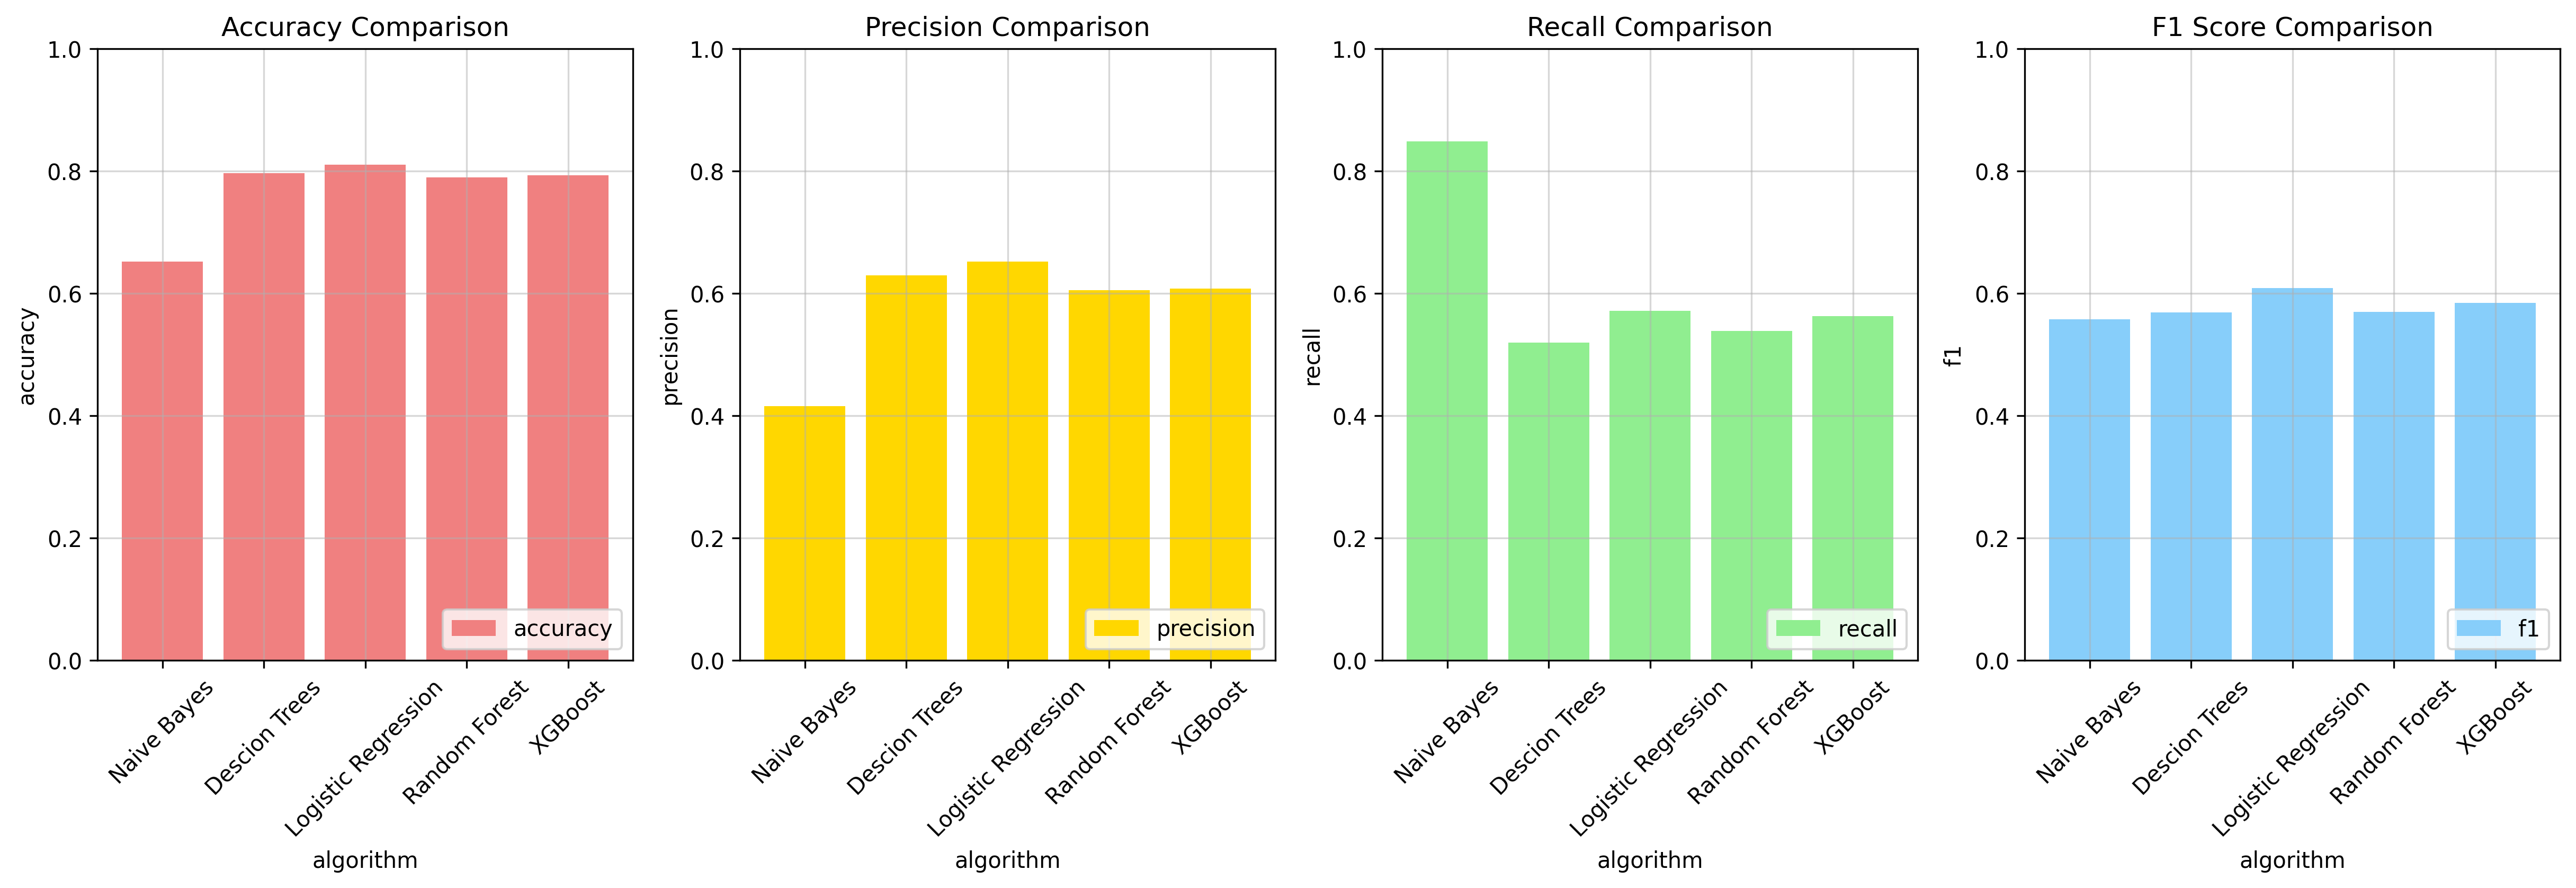

In [ ]:
# comparing all metrics for this stage of analysis
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = final_results_no_smote['method']
indices = np.arange(len(x_labels))
width = 0.3

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices,final_results_no_smote['accuracy'],color="lightcoral",alpha=1,label="accuracy")
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,final_results_no_smote['precision'],color="gold",alpha=1,label="precision")
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,final_results_no_smote['recall'],color="lightgreen",alpha=1,label="recall")
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,final_results_no_smote['f1'],color="lightskyblue",alpha=1,label="f1")
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)

We see that for this stage of analysis, the Naive Bayes classifier has the highest recall. Since we are concerned with the recall metric, in this case, the Naive Bayes classfier is the best algorithm for predicting churn in this dataset.

## Stage Two of Analysis - Predictions using SMOTE

We will now repeat the same process as above, i.e. training the dataset using the four algorithms, and generating predictions for customer churn. However, this time, we will use SMOTE (Synthetic Minority Oversampling TechniquE) methodology. This method deals with imbalances in the dataset in regards to classification labels. Normally, due to the class imbalance, the majority class will have better performance than the minority class. SMOTE deals with this by oversampling the minority class.

In [ ]:
X = df.drop(['customerID','Churn'],axis=1)
Y = df['Churn']
# splitting the data into an 80% training/20% testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.combine import SMOTEENN

sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(X_train, Y_train)

### Naive Bayes (SMOTE)

In [ ]:
# naive bayes
nb_smote = GaussianNB()
nb_smote.fit(X_resampled, y_resampled)
nb_smote_predictions = nb_smote.predict(X_test)

In [ ]:
nb_smote_accuracy_score = accuracy_score(Y_test,nb_smote_predictions)
nb_smote_precision_score = precision_score(Y_test,nb_smote_predictions)
nb_smote_recall_score = recall_score(Y_test,nb_smote_predictions)
nb_smote_f1_score = f1_score(Y_test,nb_smote_predictions)
nb_smote_confusion = confusion_matrix(Y_test,nb_smote_predictions)

In [ ]:
final_results_smote.loc[len(final_results_smote)] = ["Naive Bayes",nb_smote_accuracy_score,nb_smote_precision_score,nb_smote_recall_score,nb_smote_f1_score]

In [ ]:
# Train-test split for resampled data
xr_train, xr_test, yr_train, yr_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

# Decision Tree Classifier with SMOTEENN
model_dt_smote = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=6, min_samples_leaf=8)
model_dt_smote.fit(xr_train, yr_train)

# Predict and evaluate Decision Tree model
yr_predict = model_dt_smote.predict(xr_test)
dt_accuracy_score = accuracy_score(yr_test, yr_predict)
model_score_r = model_dt_smote.score(xr_test, yr_test)

print("Decision Tree Accuracy Score:", dt_accuracy_score)
print("Model Score (Accuracy):", model_score_r)
print(classification_report(yr_test, yr_predict))

# Storing final results
final_results_smote.loc[len(final_results_smote)] = ["Decision Tree", dt_accuracy_score, model_score_r, nb_smote_recall_score, nb_smote_f1_score]


Decision Tree Accuracy Score: 0.9352750809061489
Model Score (Accuracy): 0.9352750809061489
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       454
           1       0.93      0.94      0.94       473

    accuracy                           0.94       927
   macro avg       0.94      0.94      0.94       927
weighted avg       0.94      0.94      0.94       927



In [ ]:
final_results_smote.loc[len(final_results_smote)] = ["Decison Tree",dt_accuracy_score,model_score_r,nb_smote_recall_score,nb_smote_f1_score]

In [ ]:
from sklearn import metrics

# Train the model
model_dt_smote.fit(xr_train, yr_train)

# Make predictions
yr_predict = model_dt_smote.predict(xr_test)

# Get the accuracy score
model_score_r = model_dt_smote.score(xr_test, yr_test)  # This returns the accuracy

# Print the accuracy
print("Accuracy:", model_score_r)

# Print the classification report
print(metrics.classification_report(yr_test, yr_predict))

Accuracy: 0.948220064724919
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       437
           1       0.93      0.97      0.95       490

    accuracy                           0.95       927
   macro avg       0.95      0.95      0.95       927
weighted avg       0.95      0.95      0.95       927



### Logistic Regression (SMOTE)

In [ ]:
lr_smote = LogisticRegression(random_state=0)
lr_smote.fit(X_resampled, y_resampled)
lr_smote_predictions = lr_smote.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
lr_smote_accuracy_score = accuracy_score(Y_test,lr_smote_predictions)
lr_smote_precision_score = precision_score(Y_test,lr_smote_predictions)
lr_smote_recall_score = recall_score(Y_test,lr_smote_predictions)
lr_smote_f1_score = f1_score(Y_test,lr_smote_predictions)
lr_smote_confusion = confusion_matrix(Y_test,lr_smote_predictions)

In [ ]:
final_results_smote.loc[len(final_results_smote)] = ["Logistic Regression",lr_smote_accuracy_score,lr_smote_precision_score,lr_smote_recall_score,lr_smote_f1_score]

### Random Forest (SMOTE)

In [ ]:
rf_smote = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf_smote.fit(X_resampled, y_resampled)
rf_smote_predictions = rf_smote.predict(X_test)
rf_smote_predictions = [int(x) for x in np.round(rf_smote_predictions,0)]

In [ ]:
rf_smote_accuracy_score = accuracy_score(Y_test,rf_smote_predictions)
rf_smote_precision_score = precision_score(Y_test,rf_smote_predictions)
rf_smote_recall_score = recall_score(Y_test,rf_smote_predictions)
rf_smote_f1_score = f1_score(Y_test,rf_smote_predictions)
rf_smote_confusion = confusion_matrix(Y_test,rf_smote_predictions)

In [ ]:
final_results_smote.loc[len(final_results_smote)] = ["Random Forest",rf_smote_accuracy_score,rf_smote_precision_score,rf_smote_recall_score,rf_smote_f1_score]

### XGB Boost (SMOTE)

In [ ]:
xgb_smote = xgb.XGBClassifier()
xgb_smote.fit(X_resampled, y_resampled)
xgb_smote_predictions = xgb_smote.predict(X_test)

In [ ]:
xgb_smote_accuracy_score = accuracy_score(Y_test,xgb_smote_predictions)
xgb_smote_precision_score = precision_score(Y_test,xgb_smote_predictions)
xgb_smote_recall_score = recall_score(Y_test,xgb_smote_predictions)
xgb_smote_f1_score = f1_score(Y_test,xgb_smote_predictions)
xgb_smote_confusion = confusion_matrix(Y_test,xgb_smote_predictions)

In [ ]:
final_results_smote.loc[len(final_results_smote)] = ["XGBoost",xgb_smote_accuracy_score,xgb_smote_precision_score,xgb_smote_recall_score,xgb_smote_f1_score]

### Comparing Results for Stage Two of Analysis

Now that we have built all four models for this stage of analysis (SMOTE), we will compare the metrics of these models.

In [ ]:
# examining data table for this stage of analysis
final_results_smote

,method,accuracy,precision,recall,f1
0,Naive Bayes,0.718240,0.473768,0.818681,0.600201
1,Logistic Regression,0.734564,0.491259,0.771978,0.600427
2,Random Forest,0.760823,0.526316,0.741758,0.615735
3,XGBoost,0.751597,0.513672,0.722527,0.600457


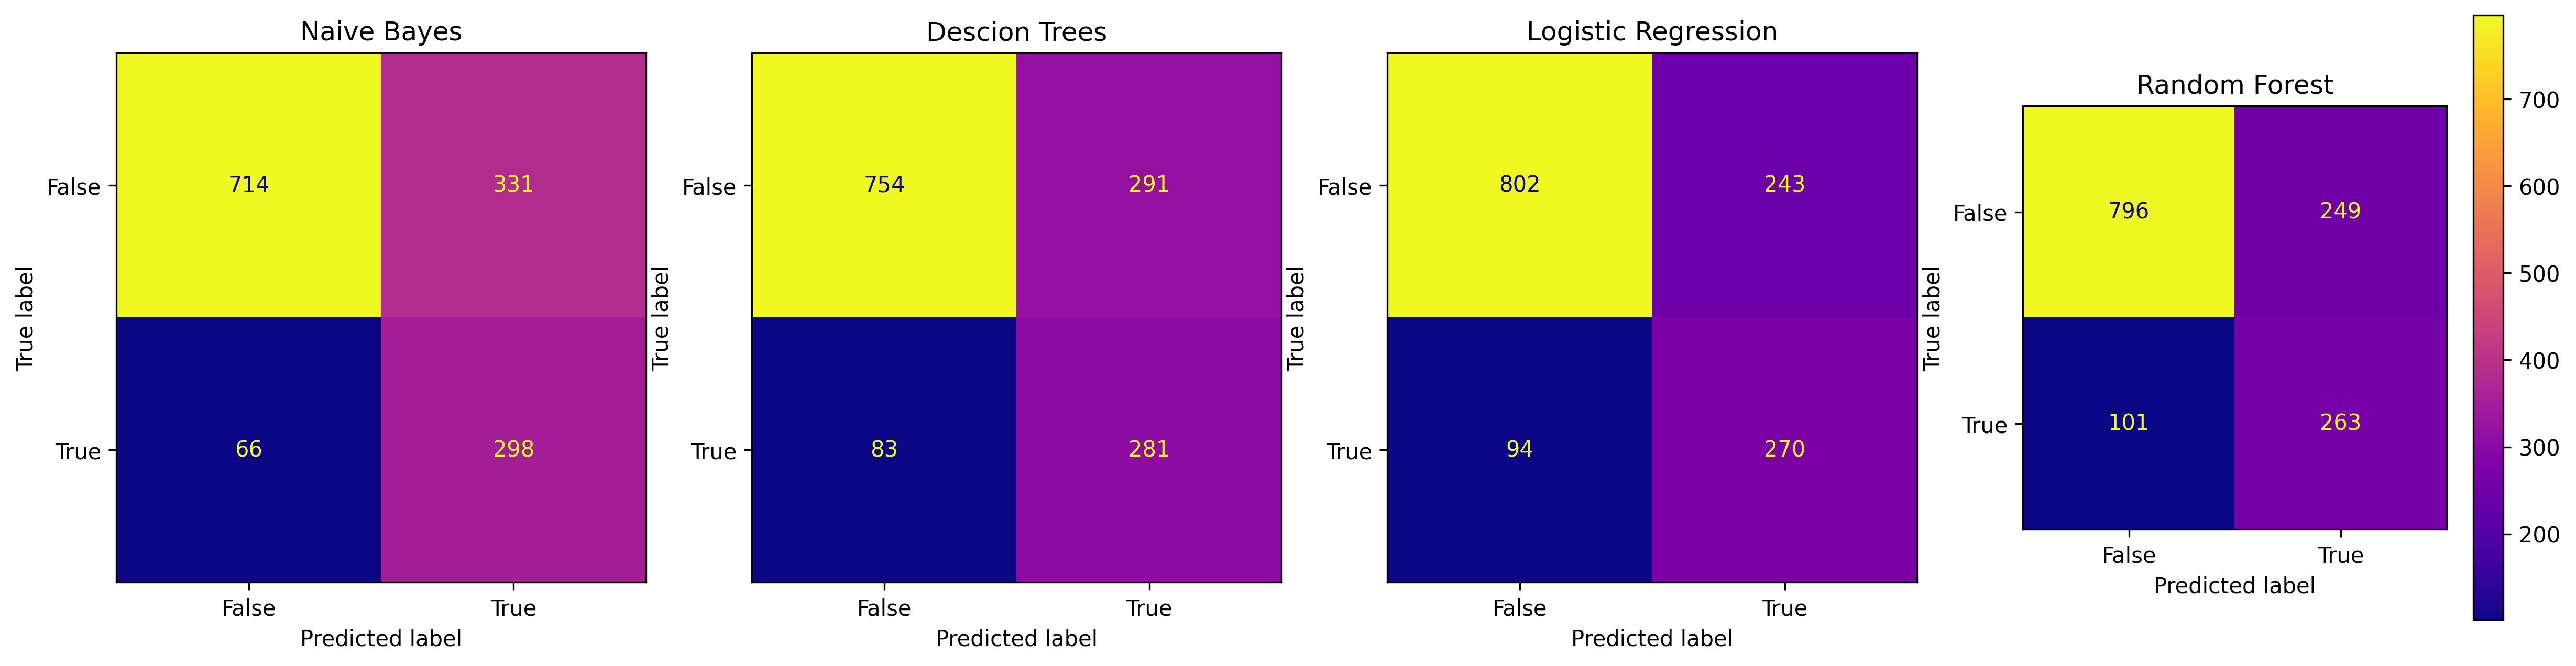

In [ ]:
# comparing confusion matrices for this stage of analysis
fig, ax = plt.subplots(1,4,sharex=False, sharey=False, figsize=(20, 5), dpi=300)
ax[0].set_title(x_labels[0])
ax[1].set_title(x_labels[1])
ax[2].set_title(x_labels[2])
ax[3].set_title(x_labels[3])

ConfusionMatrixDisplay(nb_smote_confusion,display_labels=[False,True]).plot(ax=ax[0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(lr_smote_confusion,display_labels=[False,True]).plot(ax=ax[1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(rf_smote_confusion,display_labels=[False,True]).plot(ax=ax[2],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(xgb_smote_confusion,display_labels=[False,True]).plot(ax=ax[3],cmap='plasma',colorbar=True)
fig.show()

We find that Naive Bayes has the most varied confusion matrix, but has the least number of True Negatives. The other three models have similar proportions to each other in terms of Negatives and Postives.

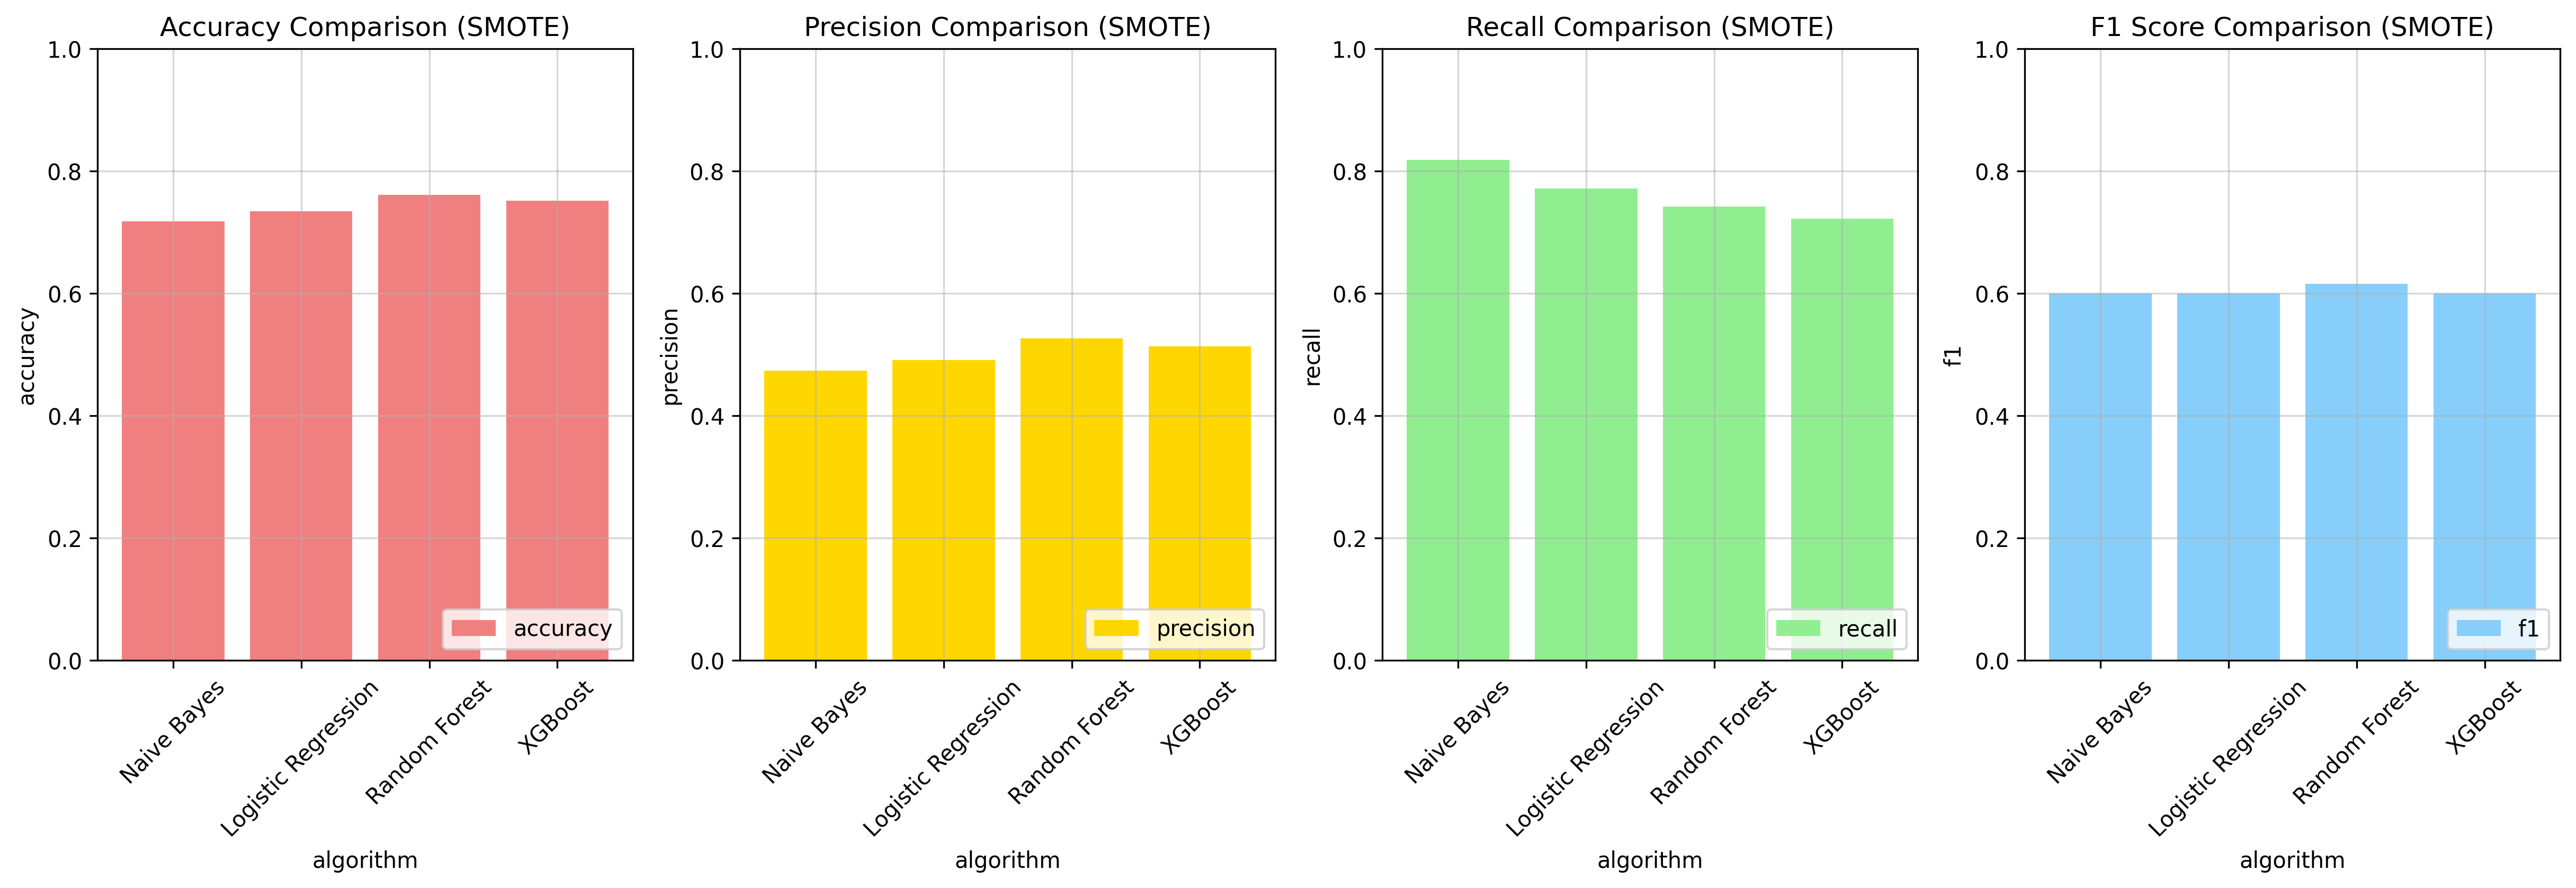

In [ ]:
# comparing all metrics for this stage of analysis
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = final_results_smote['method']
indices = np.arange(len(x_labels))
width = 0.3

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices,final_results_smote['accuracy'],color="lightcoral",alpha=1,label="accuracy")
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison (SMOTE)")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,final_results_smote['precision'],color="gold",alpha=1,label="precision")
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison (SMOTE)")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,final_results_smote['recall'],color="lightgreen",alpha=1,label="recall")
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison (SMOTE)")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,final_results_smote['f1'],color="lightskyblue",alpha=1,label="f1")
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison (SMOTE)")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)

In terms of recall, we find that the Naive Bayes method provides the best set of predictions of customer churn, compared to the other models.

## Stage Three of Analysis - Predictions using Hyperparameter Tuning (only for Random Forests and XGBoost)

### Random Forests - Hyperparameter Tuning

We will start by getting the current parameters for the Random Forest model (no SMOTE) that we obtained earlier.

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# estimating the parameters
est_rf_params = {
    'n_estimators':np.arange(10,1000,10),
    'max_features':['auto','sqrt'],
    'max_depth':np.arange(1,11,1),
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'bootstrap':[True]
}

In [ ]:
# using estimated parameter grid and doing RandomizedSearchCV before fitting
est_rf_hyp_model = RandomForestRegressor(random_state = 42)
est_rf_hyp = RandomizedSearchCV(est_rf_hyp_model,est_rf_params,n_iter=10,cv=3,n_jobs=-1)
est_rf_hyp.fit(X_train, Y_train)
est_rf_hyp_predictions = est_rf_hyp.predict(X_test)
est_rf_hyp_predictions = [int(x) for x in np.round(est_rf_hyp_predictions,0)];

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

In [ ]:
est_rf_hyp_accuracy_score = accuracy_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_precision_score = precision_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_recall_score = recall_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_f1_score = f1_score(Y_test,est_rf_hyp_predictions)
est_rf_hyp_confusio oc[len(final_results_hyp)] = ["Random Forest - RandomizedSearchCV",est_rf_hyp_accuracy_score,est_rf_hyp_precision_score,est_rf_hyp_recall_score,est_rf_hyp_f1_score]

We have obtained a first set of best hyperparameters using the RandomizedSearchCV method, which search randomly from the parameter space to obtain the best-fitting parameters. We will now pass these obtained parameters again into the model, but this time use the GridSearchCV method to see if they can be further optimized.

In [ ]:
# getting obtained best paramters from RandomizedSearchCV
rf_hyp_params = est_rf_hyp.best_params_
print(rf_hyp_params)

{'n_estimators': 780, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': True}


In [ ]:
# converting these parameters to be read
rf_hyp_param_values = {}
for key, value in rf_hyp_params.items():
    rf_hyp_param_values[key] = [value]
print(rf_hyp_param_values)

{'n_estimators': [780], 'min_samples_split': [10], 'min_samples_leaf': [1], 'max_features': ['sqrt'], 'max_depth': [8], 'bootstrap': [True]}


In [ ]:
# using obtained best parameters and doing GridSearchCV before fitting
rf_hyp_model = RandomForestRegressor(random_state = 42)
rf_hyp = GridSearchCV(rf_hyp_model,rf_hyp_param_values,cv=3,n_jobs=-1)
rf_hyp.fit(X_train, Y_train)
rf_hyp_predictions = rf_hyp.predict(X_test)
rf_hyp_predictions = [int(x) for x in np.round(rf_hyp_predictions,0)]

In [ ]:
rf_hyp_accuracy_score = accuracy_score(Y_test,rf_hyp_predictions)
rf_hyp_precision_score = precision_score(Y_test,rf_hyp_predictions)
rf_hyp_recall_score = recall_score(Y_test,rf_hyp_predictions)
rf_hyp_f1_score = f1_score(Y_test,rf_hyp_predictions)
rf_hyp_confusion = confusion_matrix(Y_test,rf_hyp_predictions)
final_results_hyp.loc[len(final_results_hyp)] = ["Random Forest - GridSearchCV",rf_hyp_accuracy_score,rf_hyp_precision_score,rf_hyp_recall_score,rf_hyp_f1_score]

### XGBoost - Hyperparameter Tuning

We repeat the same hyperparameter tuning process as before.

In [ ]:
# estimating the parameters
est_xgb_params = {
    'n_estimators':np.arange(10,1000,10),
    'max_features':['auto','sqrt'],
    'max_depth':np.arange(1,11,1),
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'bootstrap':[True]
}

In [ ]:
# using estimated parameter grid and doing RandomizedSearchCV before fitting
est_xgb_hyp_model = RandomForestRegressor(random_state = 42)
est_xgb_hyp = RandomizedSearchCV(est_xgb_hyp_model,est_xgb_params,n_iter=10,cv=3,n_jobs=-1)
est_xgb_hyp.fit(X_train, Y_train)
est_xgb_hyp_predictions = est_xgb_hyp.predict(X_test)
est_xgb_hyp_predictions = [int(x) for x in np.round(est_xgb_hyp_predictions,0)];

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

In [ ]:
est_xgb_hyp_accuracy_score = accuracy_score(Y_test,est_xgb_hyp_predictions)
est_xgb_hyp_precision_score = precision_score(Y_test,est_xgb_hyp_predictions)
est_xgb_hyp_recall_score = recall_score(Y_test,est_xgb_hyp_predictions)
est_xgb_hyp_f1_score = f1_score(Y_test,est_xgb_hyp_predictions)
est_xgb_hyp_confusion = confusion_matrix(Y_test,est_xgb_hyp_predictions)
final_results_hyp.loc[len(final_results_hyp)] = ["XGBoost - RandomizedSearchCV",est_xgb_hyp_accuracy_score,est_xgb_hyp_precision_score,est_xgb_hyp_recall_score,est_xgb_hyp_f1_score]

In [ ]:
# getting obtained best paramters from RandomizedSearchCV
xgb_hyp_params = est_xgb_hyp.best_params_
print(xgb_hyp_params)

{'n_estimators': 480, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [ ]:
# converting these parameters to be read
xgb_hyp_param_values = {}
for key, value in xgb_hyp_params.items():
    xgb_hyp_param_values[key] = [value]
print(xgb_hyp_param_values)

{'n_estimators': [480], 'min_samples_split': [10], 'min_samples_leaf': [1], 'max_features': ['sqrt'], 'max_depth': [10], 'bootstrap': [True]}


In [ ]:
# using obtained best parameters and doing GridSearchCV before fitting
xgb_hyp_model = RandomForestRegressor(random_state = 42)
xgb_hyp = GridSearchCV(xgb_hyp_model,xgb_hyp_param_values,cv=3,n_jobs=-1)
xgb_hyp.fit(X_train, Y_train)
xgb_hyp_predictions = xgb_hyp.predict(X_test)
xgb_hyp_predictions = [int(x) for x in np.round(xgb_hyp_predictions,0)];

In [ ]:
xgb_hyp_accuracy_score = accuracy_score(Y_test,xgb_hyp_predictions)
xgb_hyp_precision_score = precision_score(Y_test,xgb_hyp_predictions)
xgb_hyp_recall_score = recall_score(Y_test,xgb_hyp_predictions)
xgb_hyp_f1_score = f1_score(Y_test,xgb_hyp_predictions)
xgb_hyp_confusion = confusion_matrix(Y_test,xgb_hyp_predictions)
final_results_hyp.loc[len(final_results_hyp)] = ["XGBoost - GridSearchCV",xgb_hyp_accuracy_score,xgb_hyp_precision_score,xgb_hyp_recall_score,xgb_hyp_f1_score]

### Comparing Results (Hyperparameter Tuning)

In [ ]:
# examining data table for this stage of analysis
final_results_hyp

,method,accuracy,precision,recall,f1
0,Random Forest - RandomizedSearchCV,0.798439,0.630719,0.530220,0.576119
1,Random Forest - GridSearchCV,0.798439,0.630719,0.530220,0.576119
2,XGBoost - RandomizedSearchCV,0.798439,0.627389,0.541209,0.581121
3,XGBoost - GridSearchCV,0.798439,0.627389,0.541209,0.581121


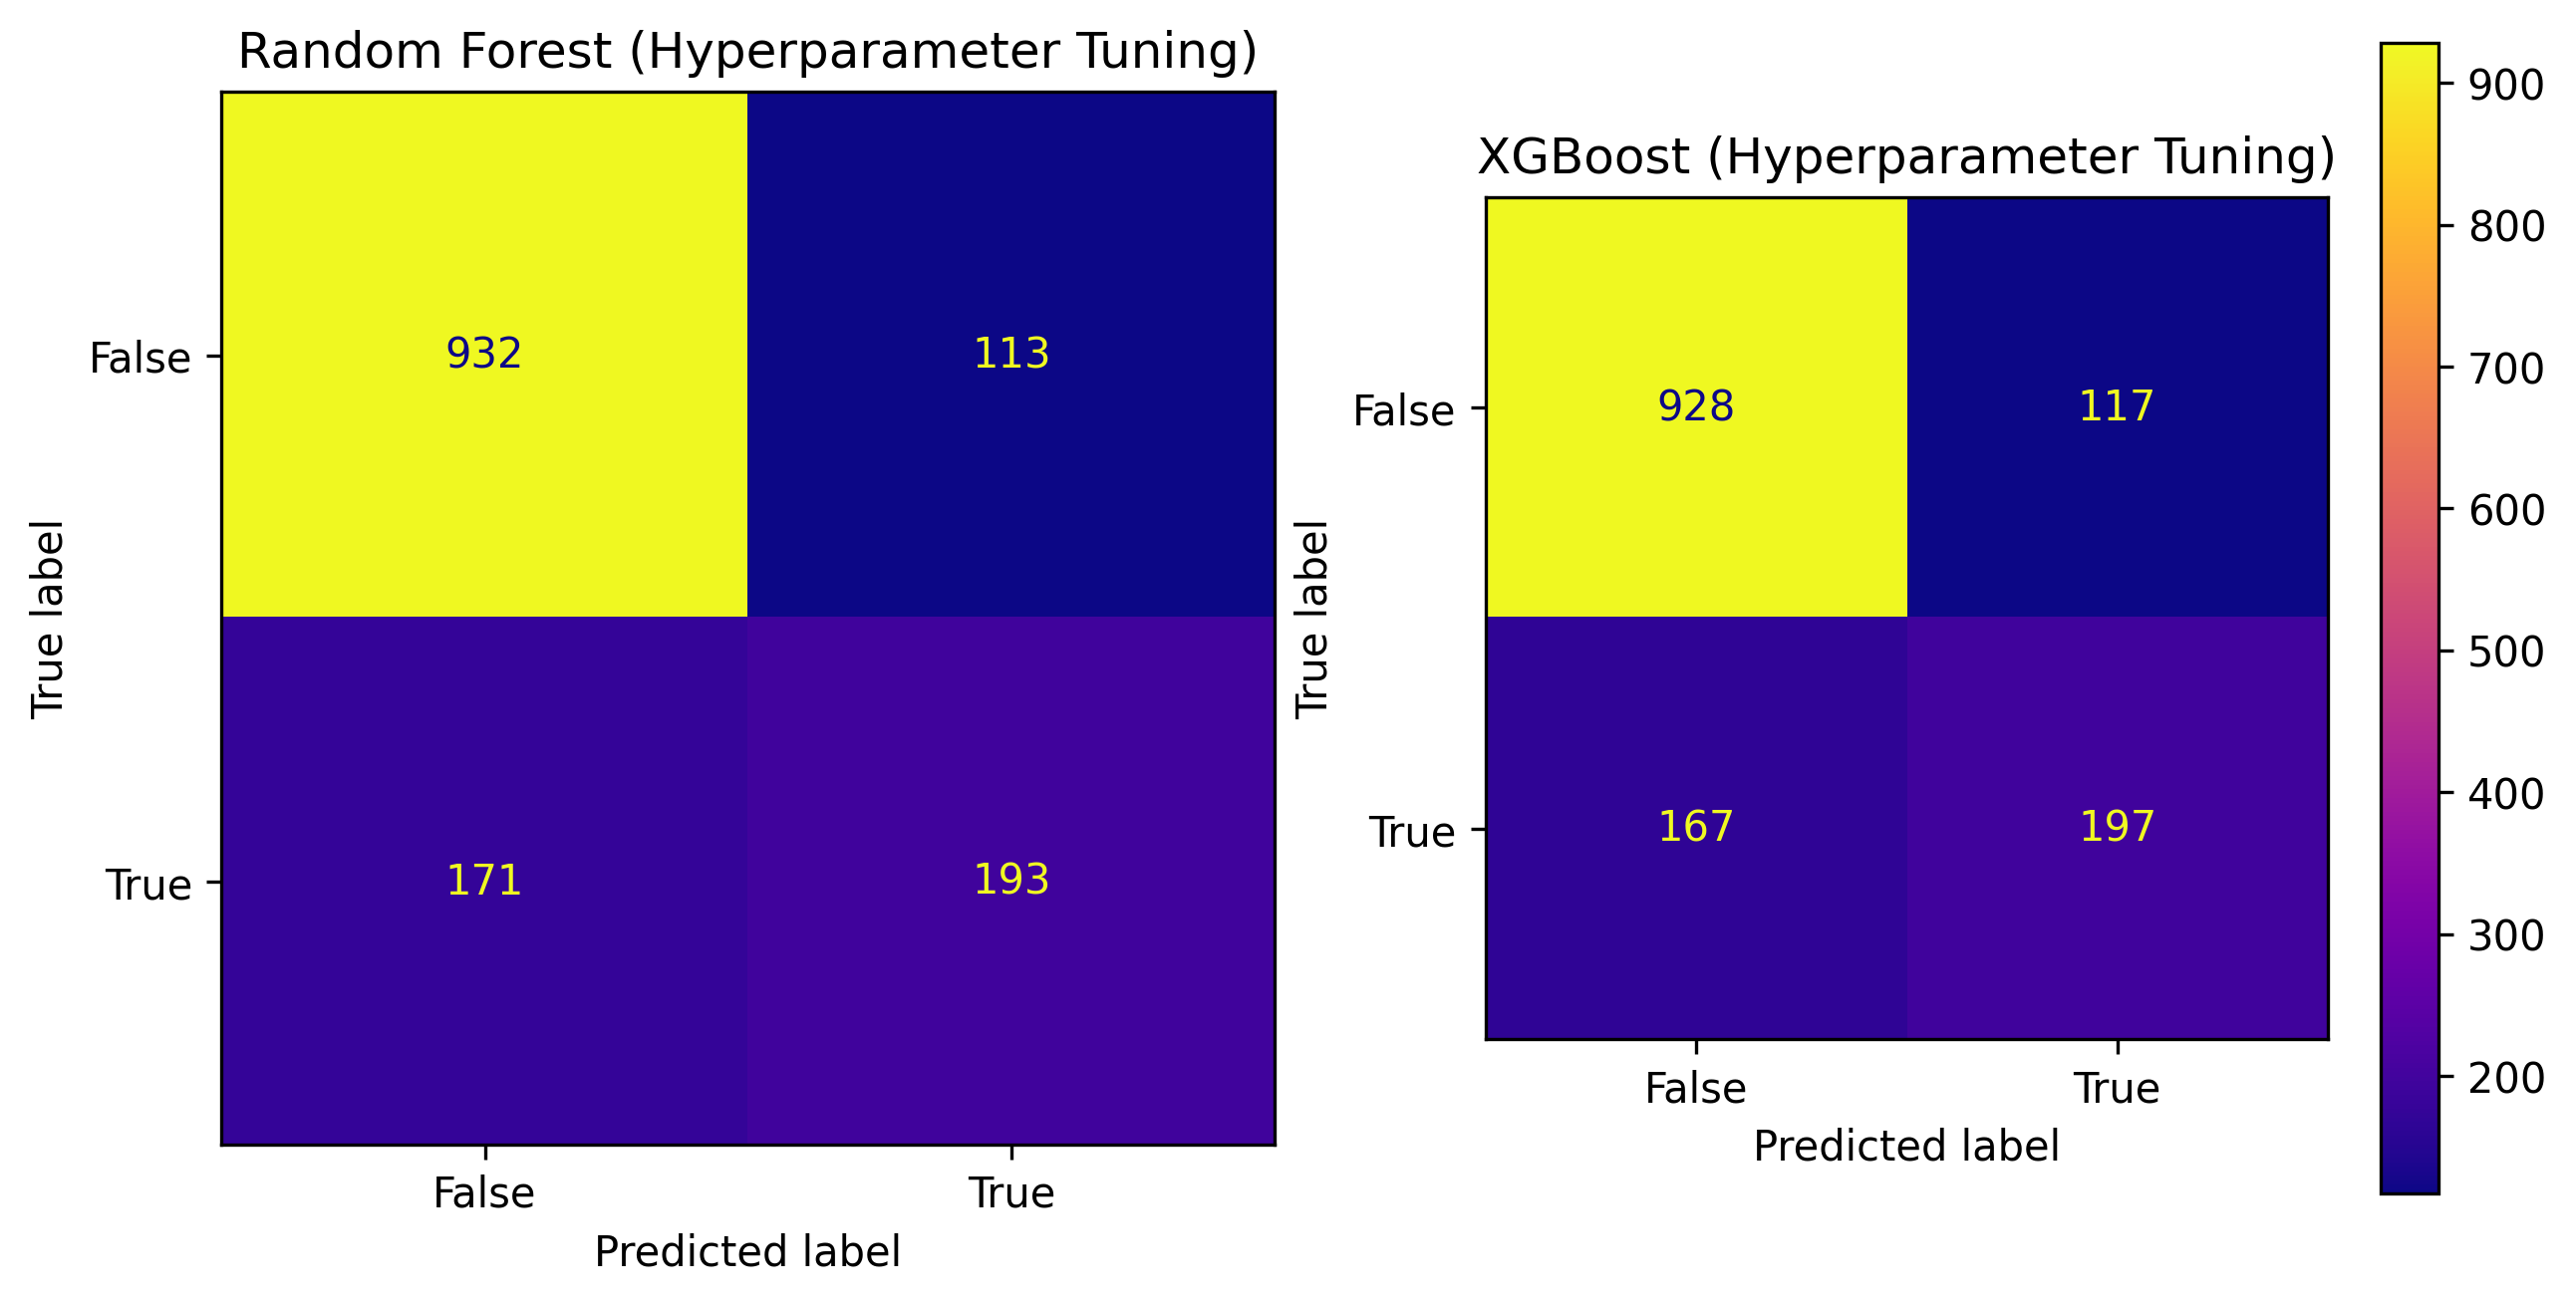

In [ ]:
# comparing confusion matrices for this stage of analysis
fig, ax = plt.subplots(1,2,sharex=False, sharey=False, figsize=(10, 5), dpi=300)
ax[0].set_title('Random Forest (Hyperparameter Tuning)')
ax[1].set_title('XGBoost (Hyperparameter Tuning)')

ConfusionMatrixDisplay(rf_hyp_confusion,display_labels=[False,True]).plot(ax=ax[0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(xgb_hyp_confusion,display_labels=[False,True]).plot(ax=ax[1],cmap='plasma',colorbar=True)
fig.show()

We find that both models have similar confusion matrices.

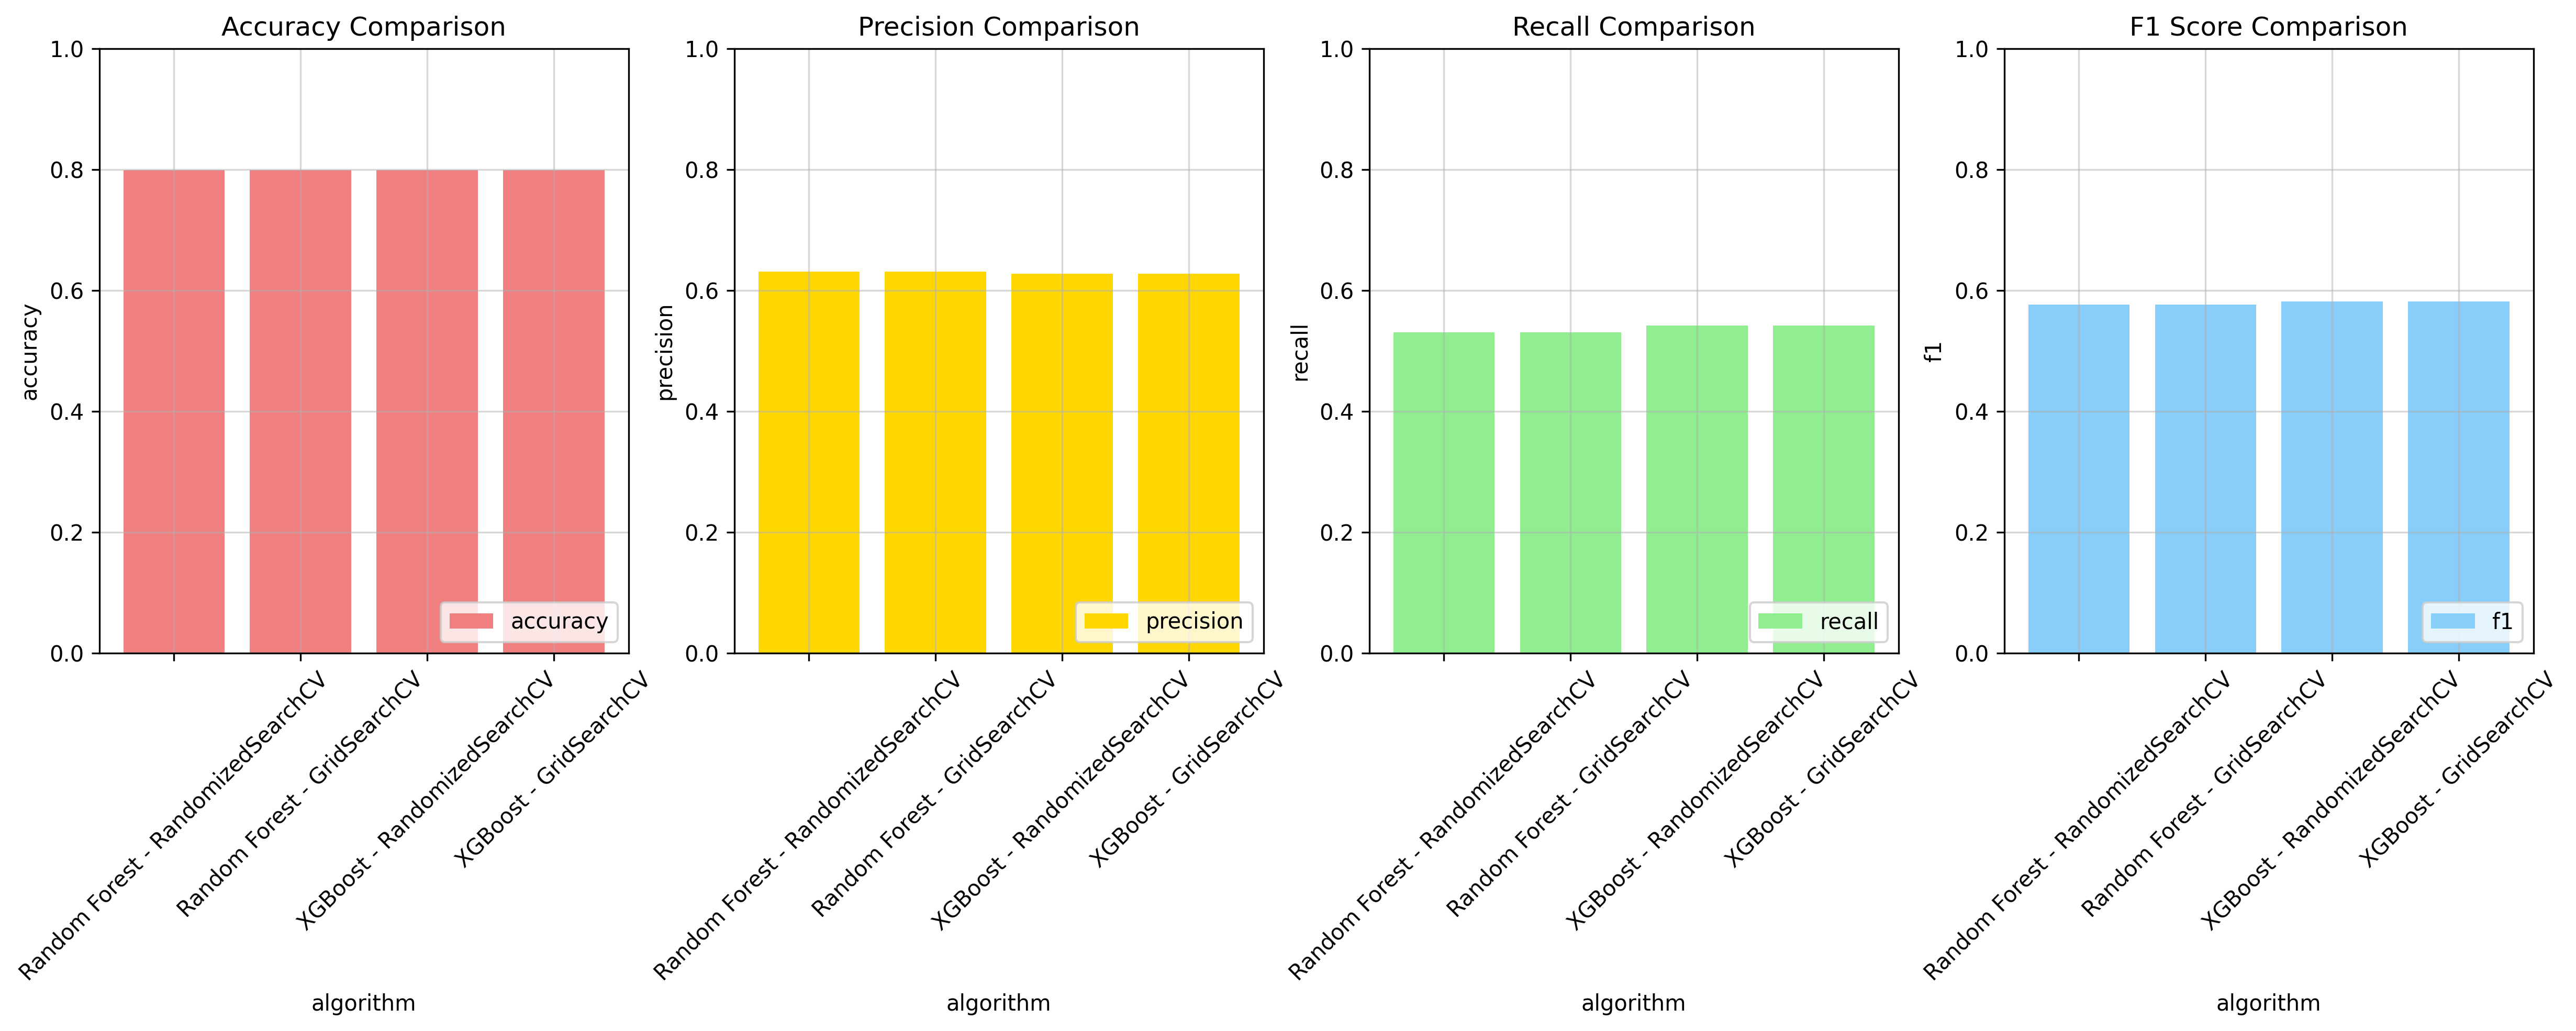

In [ ]:
# comparing all metrics for this stage of analysis
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = final_results_hyp['method']
indices = np.arange(len(x_labels))
width = 0.3

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices,final_results_hyp['accuracy'],color="lightcoral",alpha=1,label="accuracy")
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,final_results_hyp['precision'],color="gold",alpha=1,label="precision")
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,final_results_hyp['recall'],color="lightgreen",alpha=1,label="recall")
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,final_results_hyp['f1'],color="lightskyblue",alpha=1,label="f1")
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)

We find that there is no difference in each of the models' performance when we use RandomizedSearchCV first, and then use the best_params from the result and re-run the model with GridSearchCV model.

In terms of recall, we find that the Random Forest model performs slightly better than XGBoost. However, both models provide very similar performances compared to each other for each of the 4 metrics.

Now we will compare the results of hyperparameter tuning with the first two stages of analysis - non-SMOTE and SMOTE.

In [ ]:
# preparing dataframes for comparing all three stages of analysis
pre_hyp_comparison_no_smote = final_results_no_smote[2:4]
pre_hyp_comparison_smote = final_results_smote[2:4]
post_hyp_comparison = final_results_hyp.iloc[[0,2]]

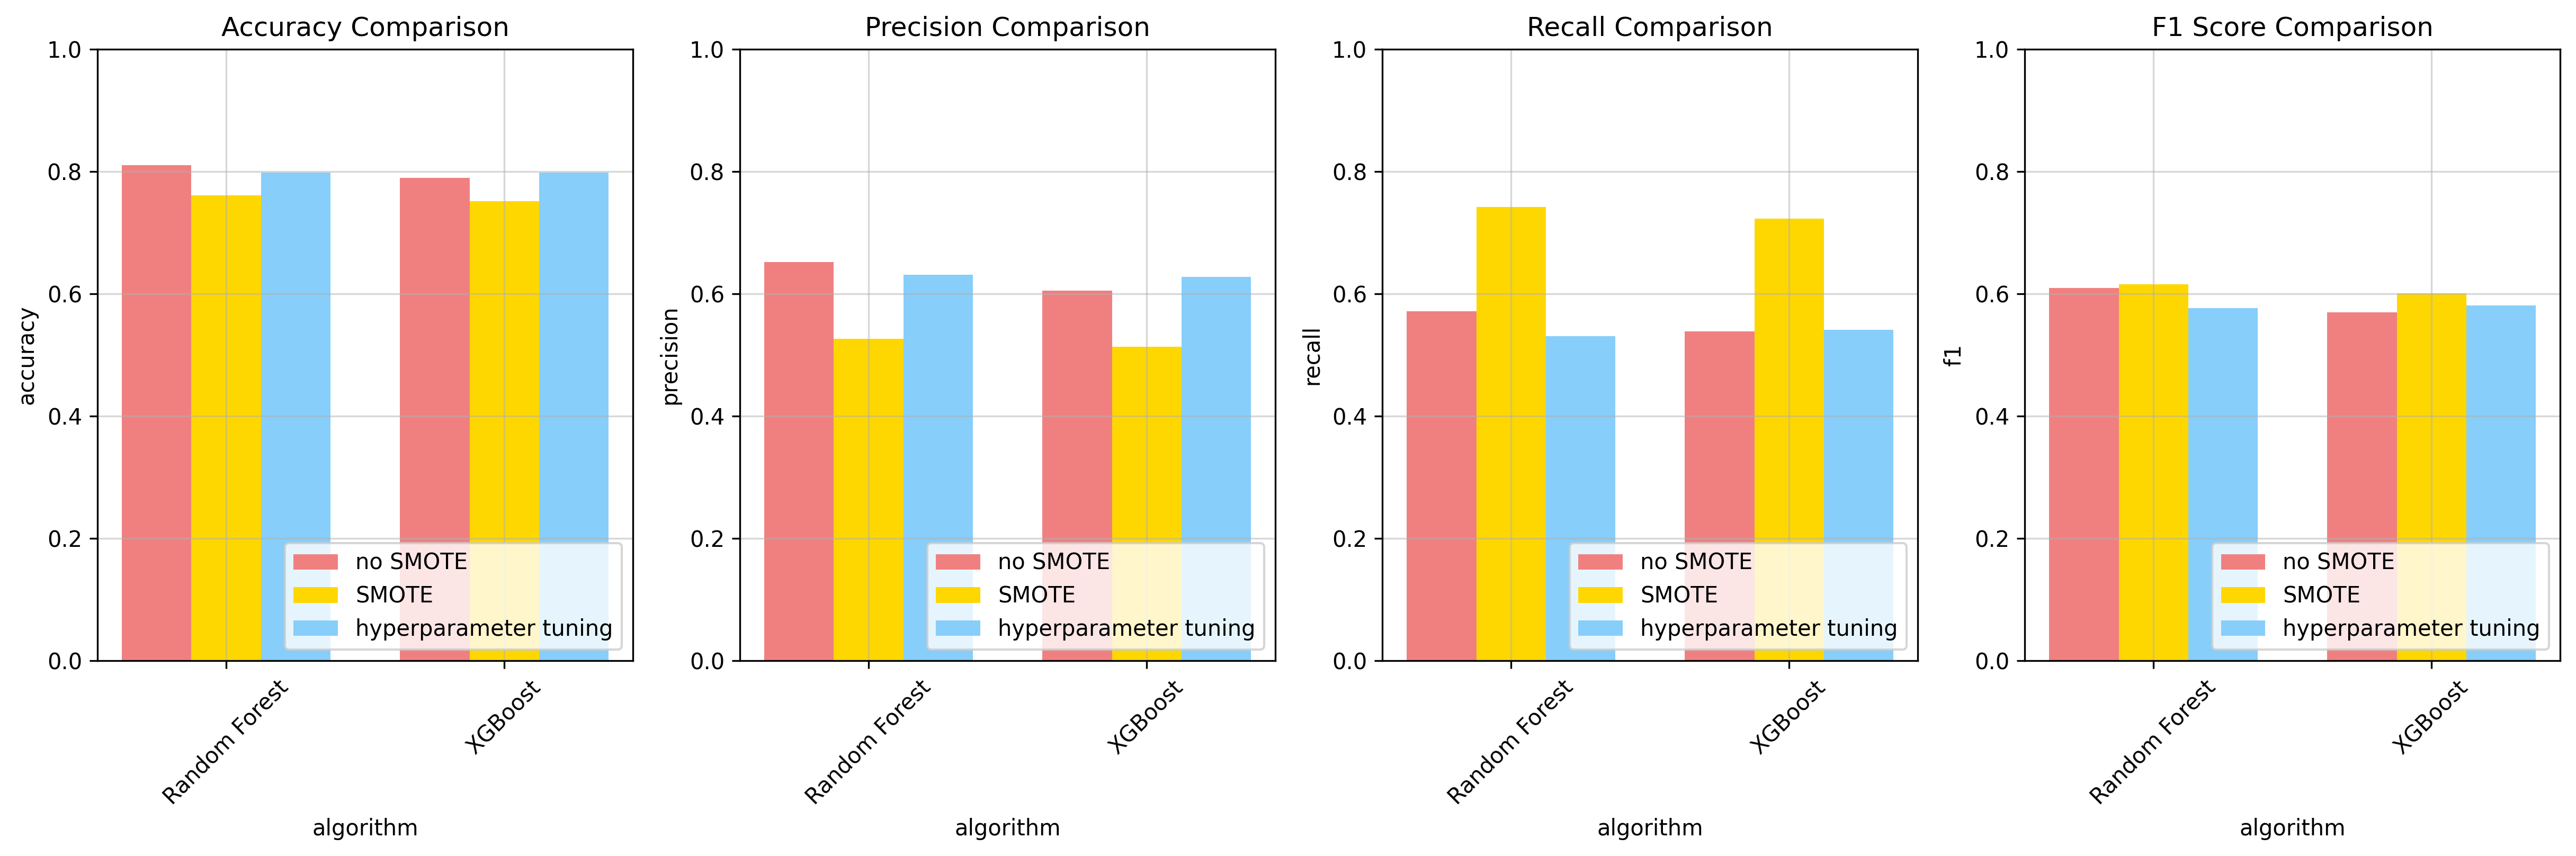

In [ ]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = ['Random Forest','XGBoost']
indices = np.arange(len(x_labels))
width = 0.25

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices+width,pre_hyp_comparison_no_smote['accuracy'],width,color="lightcoral",alpha=1,label="no SMOTE")
ax[0].bar(indices+2*width,pre_hyp_comparison_smote['accuracy'],width,color="gold",alpha=1,label="SMOTE")
ax[0].bar(indices+3*width,post_hyp_comparison['accuracy'],width,color="lightskyblue",alpha=1,label="hyperparameter tuning")
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices+2*width, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices+width,pre_hyp_comparison_no_smote['precision'],width,color="lightcoral",alpha=1,label="no SMOTE")
ax[1].bar(indices+2*width,pre_hyp_comparison_smote['precision'],width,color="gold",alpha=1,label="SMOTE")
ax[1].bar(indices+3*width,post_hyp_comparison['precision'],width,color="lightskyblue",alpha=1,label="hyperparameter tuning")
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices+2*width, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices+width,pre_hyp_comparison_no_smote['recall'],width,color="lightcoral",alpha=1,label="no SMOTE")
ax[2].bar(indices+2*width,pre_hyp_comparison_smote['recall'],width,color="gold",alpha=1,label="SMOTE")
ax[2].bar(indices+3*width,post_hyp_comparison['recall'],width,color="lightskyblue",alpha=1,label="hyperparameter tuning")
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices+2*width, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices+width,pre_hyp_comparison_no_smote['f1'],width,color="lightcoral",alpha=1,label="no SMOTE")
ax[3].bar(indices+2*width,pre_hyp_comparison_smote['f1'],width,color="gold",alpha=1,label="SMOTE")
ax[3].bar(indices+3*width,post_hyp_comparison['f1'],width,color="lightskyblue",alpha=1,label="hyperparameter tuning")
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices+2*width, x_labels, rotation=45)

When comparing the results for all three stages of analysis, we see that in terms of recall, SMOTE analysis provided the best results for each of Random Forest and XGBoost models, over the non-SMOTE and hyperparameter tuning methods.

## Comparison of all Stages of Analysis

## Conclusion

To conclude this project, we will first rank the best results for each stage of analysis, and then rank the best results overall for this dataset in terms of predicting churn values. We split our data into an 80% training set and 20% testing set. We used the recall metric as the defining metric, due to it being proportionate with the number of True Negatives in terms of predictions, i.e. models with higher recall values are the best for predicting churned customers because there are significantly less True Negatives in the predictions.

### Stage One of Analysis: Normal Predictions

1. Naive Bayes
2. XGBoost
3. Logistic Regression
4. Random Forest

### Stage Two of Analysis: Predictions using SMOTE

1. Naive Bayes
2. Logistic Regression
3. Random Forest
4. XGBoost

### Stage Three of Analysis - Predictions using Hyperparameter Tuning (only for Random Forests and XGBoost)

1. Random Forest
2. XGBoost

### Overall (all stages of analysis)

1. Naive Bayes

(for a more detailed breakdown of overall results, see the table below, sorted by Recall values)

In [ ]:
import pandas as pd

# Replace values in `final_results_smote`
tmp_final_results_smote = final_results_smote.replace({
    'Naive Bayes': 'Naive Bayes (SMOTE)',
    'Logistic Regression': 'Logistic Regression (SMOTE)',
    'Random Forest': 'Random Forest (SMOTE)',
    'XGBoost': 'XGBoost (SMOTE)'
})

# Use `pd.concat()` instead of `append()` to combine DataFrames
all_results_combined = pd.concat([final_results_no_smote, tmp_final_results_smote, final_results_hyp])

# Sort and reset the index
final_results = all_results_combined.sort_values('recall', ascending=False).reset_index(drop=True)


In [ ]:
final_results

,method,accuracy,precision,recall,f1
0,Naive Bayes,0.652236,0.415323,0.848901,0.557762
1,Naive Bayes (SMOTE),0.718240,0.473768,0.818681,0.600201
2,Decison Tree,0.948220,0.948220,0.818681,0.600201
3,Decision Tree,0.948220,0.948220,0.818681,0.600201
4,Decision Tree,0.935275,0.935275,0.818681,0.600201
5,Logistic Regression (SMOTE),0.734564,0.491259,0.771978,0.600427
6,Random Forest (SMOTE),0.760823,0.526316,0.741758,0.615735
7,XGBoost (SMOTE),0.751597,0.513672,0.722527,0.600457
8,Logistic Regression,0.810504,0.652038,0.571429,0.609078
9,XGBoost,0.793471,0.608309,0.563187,0.584879


In [ ]:
# Import necessary libraries for data handling, visualization, and analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load dataset (replace 'healthcare_data.csv' with the actual path to your dataset)
data = pd.read_csv("healthcare_data.csv")

# Initial data exploration
print("First five rows of the dataset:")
print(data.head())
print("\nSummary of dataset:")
print(data.info())

# Display unique values for each column to determine required conversions
print("\nUnique values in each column:")
for feature in data.columns:
    print(f"{feature}: {data[feature].unique()}")

# Encoding categorical features to numeric values (modify as per your dataset's categories)
for feature in data.columns:
    if data[feature].dtype == 'object':
        data.loc[data[feature] == "Yes", feature] = 1
        data.loc[data[feature] == "No", feature] = 0
        data.loc[data[feature] == "Female", feature] = 0
        data.loc[data[feature] == "Male", feature] = 1
        data.loc[data[feature] == " ", feature] = -1  # For missing values

# Convert all remaining categorical columns to integers, except identifier columns if present
target_columns = data.columns[data.dtypes == "object"]
for feature in target_columns:
    data[feature] = pd.to_numeric(data[feature], errors='coerce')

# Fill missing values with median values for simplicity (customize as needed)
data = data.fillna(data.median())

# Drop non-informative columns (e.g., 'patient_id') if they exist
if 'patient_id' in data.columns:
    data = data.drop(['patient_id'], axis=1)

# Exploratory Data Analysis (EDA)
# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# Generate descriptive statistics
print("\nDescriptive Statistics:")
print(data.describe())

# Target variable (assuming 'Outcome' or adjust for your dataset's target)
target_column = 'Outcome'  # Replace with the actual target column in your dataset
X = data.drop([target_column], axis=1)
Y = data[target_column]

# Split data for training and testing (80% training, 20% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize DataFrames to store evaluation metrics for each model
metric_columns = ["model", "accuracy", "precision", "recall", "f1"]
no_smote_metrics = pd.DataFrame(columns=metric_columns)

# Evaluate models without SMOTE
# Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, Y_train)
nb_pred = nb_model.predict(X_test)
no_smote_metrics.loc[len(no_smote_metrics)] = ["Naive Bayes", accuracy_score(Y_test, nb_pred),
                                                precision_score(Y_test, nb_pred),
                                                recall_score(Y_test, nb_pred), f1_score(Y_test, nb_pred)]

# Decision Tree model
dt_model = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=6, min_samples_leaf=8)
dt_model.fit(X_train, Y_train)
dt_pred = dt_model.predict(X_test)
no_smote_metrics.loc[len(no_smote_metrics)] = ["Decision Tree", accuracy_score(Y_test, dt_pred),
                                                precision_score(Y_test, dt_pred),
                                                recall_score(Y_test, dt_pred), f1_score(Y_test, dt_pred)]

# Logistic Regression
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, Y_train)
lr_pred = lr_model.predict(X_test)
no_smote_metrics.loc[len(no_smote_metrics)] = ["Logistic Regression", accuracy_score(Y_test, lr_pred),
                                                precision_score(Y_test, lr_pred),
                                                recall_score(Y_test, lr_pred), f1_score(Y_test, lr_pred)]

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, Y_train)
rf_pred = np.round(rf_model.predict(X_test)).astype(int)
no_smote_metrics.loc[len(no_smote_metrics)] = ["Random Forest", accuracy_score(Y_test, rf_pred),
                                                precision_score(Y_test, rf_pred),
                                                recall_score(Y_test, rf_pred), f1_score(Y_test, rf_pred)]

# XGBoost Classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, Y_train)
xgb_pred = xgb_model.predict(X_test)
no_smote_metrics.loc[len(no_smote_metrics)] = ["XGBoost", accuracy_score(Y_test, xgb_pred),
                                                precision_score(Y_test, xgb_pred),
                                                recall_score(Y_test, xgb_pred), f1_score(Y_test, xgb_pred)]

# Display model evaluation metrics without SMOTE
print("\nModel Performance without SMOTE:")
print(no_smote_metrics)

# Plotting metrics comparison
fig, ax = plt.subplots(1, 4, sharex=True, figsize=(20, 5), dpi=300)
x_labels = no_smote_metrics['model']
indices = np.arange(len(x_labels))
width = 0.3

ax[0].bar(indices, no_smote_metrics['accuracy'], color='b', width=width)
ax[0].set_title('Accuracy')

ax[1].bar(indices, no_smote_metrics['precision'], color='g', width=width)
ax[1].set_title('Precision')

ax[2].bar(indices, no_smote_metrics['recall'], color='r', width=width)
ax[2].set_title('Recall')

ax[3].bar(indices, no_smote_metrics['f1'], color='y', width=width)
ax[3].set_title('F1 Score')

plt.suptitle("Model Performance Metrics Comparison")
for i in range(4):
    ax[i].set_xticks(indices)
    ax[i].set_xticklabels(x_labels, rotation=45, ha='right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Confusion Matrix for XGBoost model as an example
ConfusionMatrixDisplay.from_predictions(Y_test, xgb_pred)
plt.title("Confusion Matrix for XGBoost")
plt.show()
